In [1]:
### Imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-poster')
from matplotlib.pyplot import *
from datetime import timedelta
import calendar # for getting month name i.e. Feb from month number
from urllib.request import urlretrieve # for getting data from URLs
from datetime import datetime
import datetime as dt
import os # for deleting files
import statsmodels
import statsmodels.api as sm # for time series decomposition
from statsmodels.tsa.filters.hp_filter import hpfilter # for Hodrick-Prescott filter
%matplotlib inline

In [2]:
### Get data ###
def get_data(location_input):
    '''Returns data for desired location.
    
    Keyword arguments:
    location -- string of location wanted.
    '''
    # Dictionary of URLs from different locations
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    Burton_On_Trent_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2018.csv'  
    } # no 2017 data for Burton
    
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre,
      "Burton_Centre" : Burton_On_Trent_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string # so that these can be used outside of function
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
   
    # Making dataframes
    df_2020 = pd.read_csv(URL_2020,skiprows=4)
    df_2019 = pd.read_csv(URL_2019,skiprows=4)
    df_2018 = pd.read_csv(URL_2018,skiprows=4)
    df_2017 = pd.read_csv(URL_2017,skiprows=4)
    
    print('Successfully got data for {}!'.format(location_input))

In [3]:
get_data('Derby')

Successfully got data for Derby!


In [4]:
### Cleaning data ###
def datetime_cleaner(variable):
    '''Take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00. 
    Also removes redundant columns
    
    Keyword arguments:
    variable -- the dataframe inputted i.e. df_2020
    '''
    # Changing date from object to datetime
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y') # makes sure string is in correct format
    variable['Date'] = pd.to_datetime(variable['Date']) # converts to datetime
    
    # Loop to add 1 for every 24th entry, as they are stored as date x & 24:00 when they need to be date x + 1 & 00:00
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    
    # Replacing 24:00 with 00:00
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00') 
    
    # Combining date and time columns
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    
    # Feature Engineering
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Month'] = variable['Date Time'].dt.month
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    
    # Setting index to be Date Time
    variable.index = variable['Date Time']
    
    # Removing columns
    variable.drop(['Date','time','Date String','Date Time String'],axis=1,inplace=True)
    variable.drop(['status','unit','status.1','unit.1','status.2','unit.2'],axis=1,inplace=True)
          
    # Removing columns that only exists in some locations (i.e. Reading has 'unit.3') whereas Derby doesn't
    variable.drop(['status.3','unit.3'],axis=1,inplace=True,errors='ignore') 

In [5]:
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

# removing null values (data doesn't start until 2017-01-20 11:00:00)
df_all_nonull = df_all.dropna()

# Pollution per *hour*

Text(0, 0.5, 'ugm$^3$')

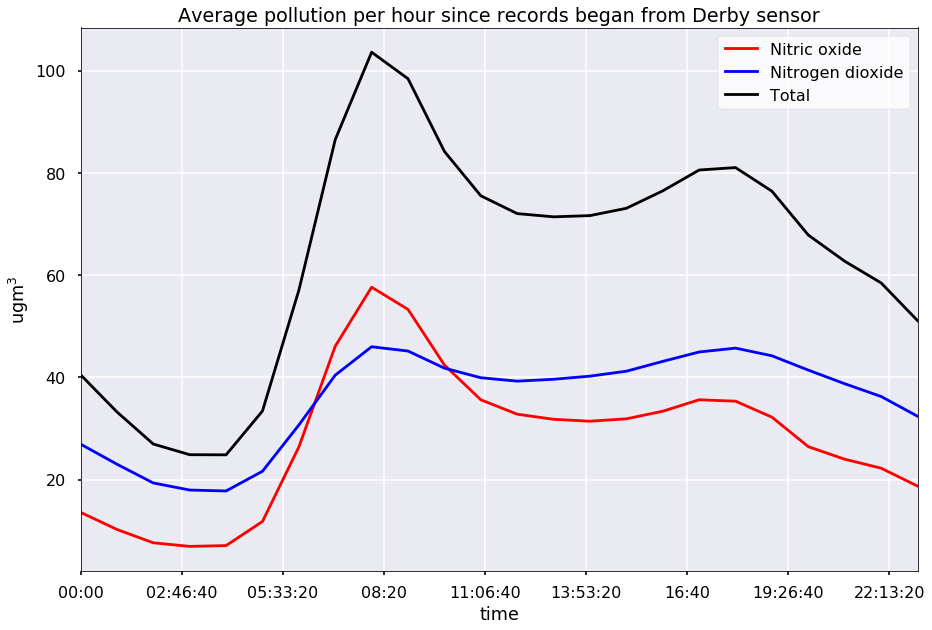

In [6]:
plt.style.use('seaborn-poster')


fig = df_all[['Nitric oxide','Nitrogen dioxide','Total']].groupby(df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10],color=['r','b','k'])

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Average pollution per hour since records began from {} sensor'.format(location_string))
plt.ylabel('ugm$^3$')

### 2020 hourly pollution since lockdown compared to same time period for previous years

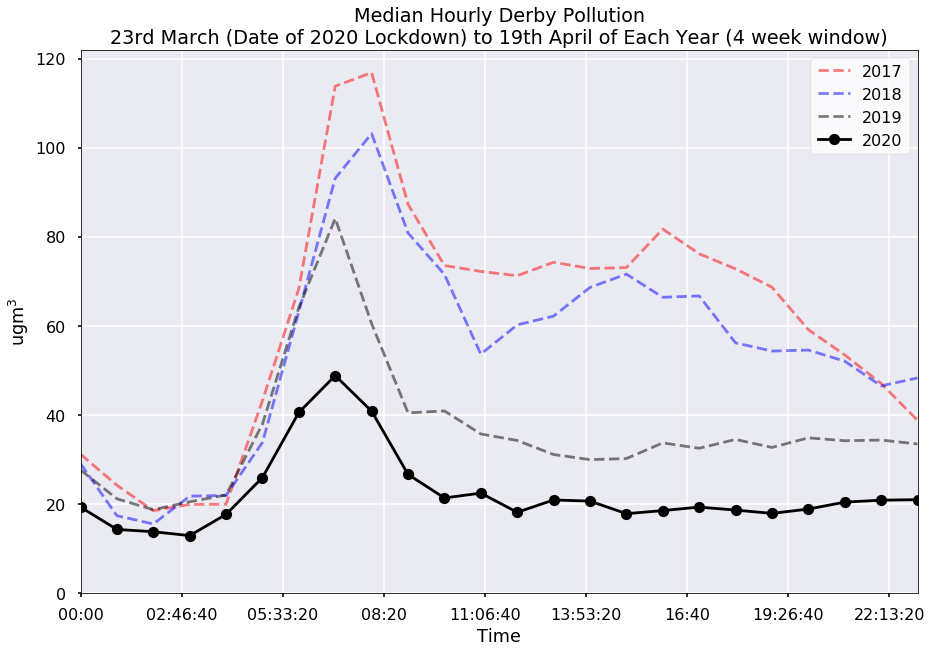

In [7]:
plt.style.use('seaborn-poster')

# 2017 March hourly 
fig = df_2017.loc['2017-03-23':'2017-04-19']['Total'].groupby(
    df_2017.loc['2017-03-23':'2017-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['r'],alpha=0.5, ls='--',
                                                                       label='2017')
# 2018 March hourly 
fig = df_2018.loc['2018-03-23':'2018-04-19']['Total'].groupby(
    df_2018.loc['2018-03-23':'2018-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['b'],alpha=0.5, ls='--',
                                                                       label='2018')
# 2019 March hourly 
fig = df_2019.loc['2019-03-23':'2019-04-19']['Total'].groupby(
    df_2019.loc['2019-03-23':'2019-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['k'],alpha=0.5, ls='--',
                                                                       label='2019')
# 2020 March hourly 
fig = df_2020.loc['2020-03-23':'2020-04-19']['Total'].groupby(
    df_2020.loc['2020-03-23':'2020-04-19']['Total'].index.time).median().plot(
    figsize=[15,10],color=['k'], label='2020',marker='o')

# Stylings
plt.legend()
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Median Hourly {} Pollution\n23rd March (Date of 2020 Lockdown) to 19th April of Each Year (4 week window)'.format(location_string))
plt.ylabel('ugm$^3$')
plt.xlabel('Time')
fig.set_ylim(0,None)
plt.savefig('Images/01. 4 Week Window Post Lockdown.png',bbox_inches='tight')

# Pivot tables

## 1) Plot each year by week number

In [8]:
# Making weekly pivot table (of only full weeks)
df_all_ = df_all.loc['2017-01-01':'2020-04-19'] # so it only plots full weeks
weekly = df_all_.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

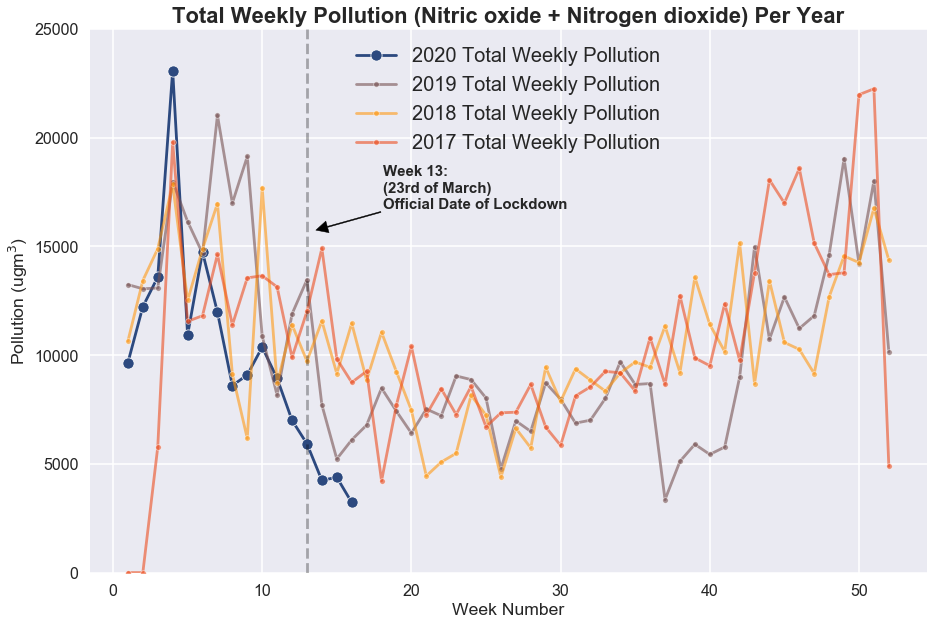

In [9]:
# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')

x = plt.figure(figsize=(15,10))
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
             alpha=0.6,color='#EC4E20',marker='.',ci=None)


plt.axvline(13, 0, 1,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.27,0.63),
                     xytext=(0.35,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('Pollution (ugm$^3$)')
plt.xlabel('Week Number')
plt.title('Total Weekly Pollution (Nitric oxide + Nitrogen dioxide) Per Year',fontdict={'fontweight':'bold','fontsize':22})
x.set_ylim(0,25000)

plt.savefig('Images/02. Weekly Pollution All Years.png',bbox_inches='tight')

### Pivot table showing *only some* weeks of the year, to improve readability

In [10]:
# First, make pivot table
pivoted_limited = pivoted.iloc[0:20]

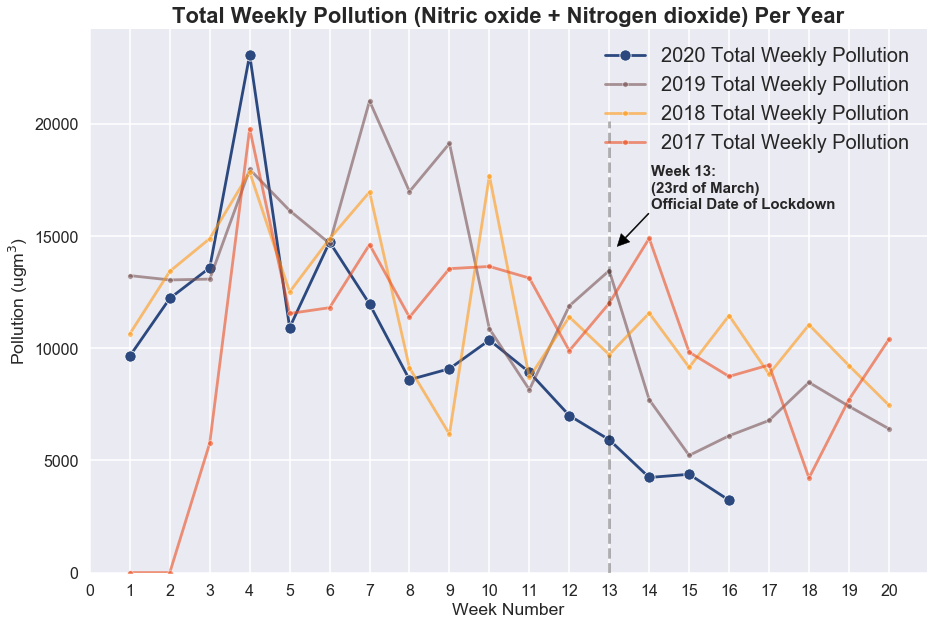

In [11]:
# plotting data
x = plt.figure(figsize=(15,10))
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2017'],label='2017 Total Weekly Pollution',
             alpha=0.6,color='#EC4E20',marker='.',ci=None)

plt.axvline(13, 0, 0.83,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.63,0.60),
                     xytext=(0.67,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper right',fontsize=20)
plt.ylabel('Pollution (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution (Nitric oxide + Nitrogen dioxide) Per Year',fontdict={'fontweight':'bold','fontsize':22})

plt.savefig('Images/03. Weekly Pollution All Years Zoomed.png',bbox_inches='tight')

# Comparing 2020 to *median* value of previous years (easier to read)

In [12]:
# Making new column in pivot table: median of 2017 & 2018 & 2019
z = pivoted.loc[:,['2017','2018','2019']].median(axis=1)
pivoted['Median Over Previous Years'] = z

# Making new column in pivot table: mean of 2017 & 2018 & 2019 9 (why not)
y = pivoted.loc[:,['2017','2018','2019']].mean(axis=1)
pivoted['Mean Over Previous Years'] = y

# New columns: 2020 as % of median, and 2020 % change from median
pivoted['% Of Median'] = (pivoted['2020']/pivoted['Median Over Previous Years'])*100
pivoted['% Change From Median'] = ((pivoted['2020']/pivoted['Median Over Previous Years'])-1)*100

# Column to indicate if weekly value for 2020 is higher or lower than median 
pivoted.loc[pivoted['% Of Median'] >= 100, 'High Or Low'] = 'Higher Than Median'
pivoted.loc[pivoted['% Of Median'] < 100, 'High Or Low'] = 'Lower Than Median'

# New dataframe containing just median of previous years, 2020, % of median, % change from median, mean (i.e. dropp prev years)
pivoted_clean = pivoted.iloc[:,[4,3,5,6,7,8]]

# Making smaller "limited" pivot_clean not showing all weeks
pivoted_clean_limited = pivoted_clean.iloc[:20,:]

### Above heatmap as line plot

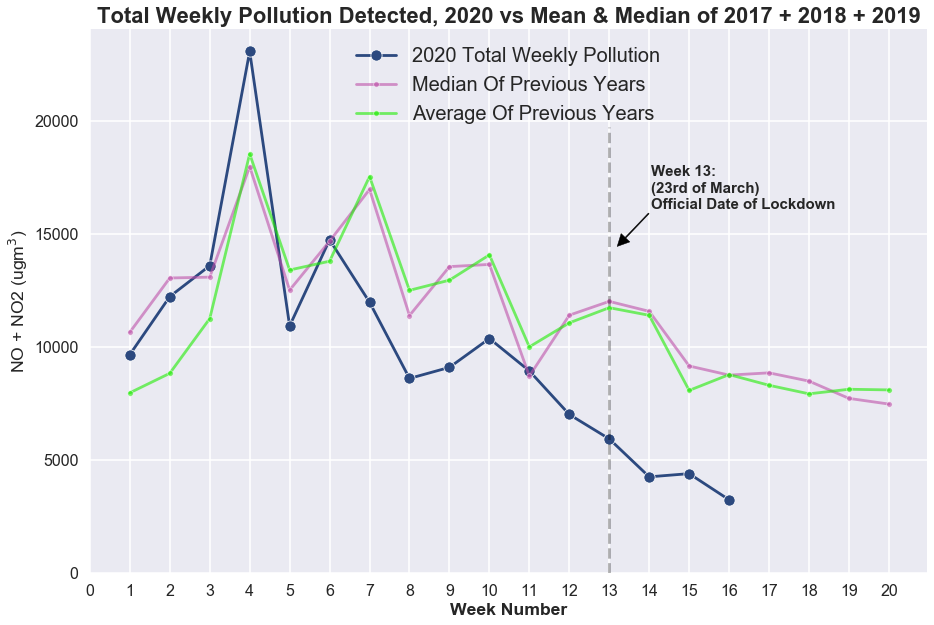

In [13]:
# plotting data
x = plt.figure(figsize=(15,10))
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['Median Over Previous Years'],
                 label='Median Of Previous Years',alpha=0.6,color='#be51a9',marker='.',ci=None)
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['Mean Over Previous Years'],
                 label='Average Of Previous Years',alpha=0.6,color='#1fed03',marker='.',ci=None)

plt.axvline(13, 0, 0.82,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.63,0.60),
                     xytext=(0.67,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('NO + NO2 (ugm$^3$)')
#plt.ylabel('Nitric oxide + Nitrogen dioxide (ugm$^3$)')
plt.xlabel('Week Number',fontdict={'fontweight':'bold'})
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019',
         fontdict={'fontweight':'bold','fontsize':22})
plt.savefig('Images/04. Weekly 2020 Pollution VS Mean and Median.png',bbox_inches='tight')
plt.savefig('Images/04. Weekly 2020 Pollution VS Mean and Median Transparent.png',transparent=True)

# would be great to also say % drop compared to median and mean

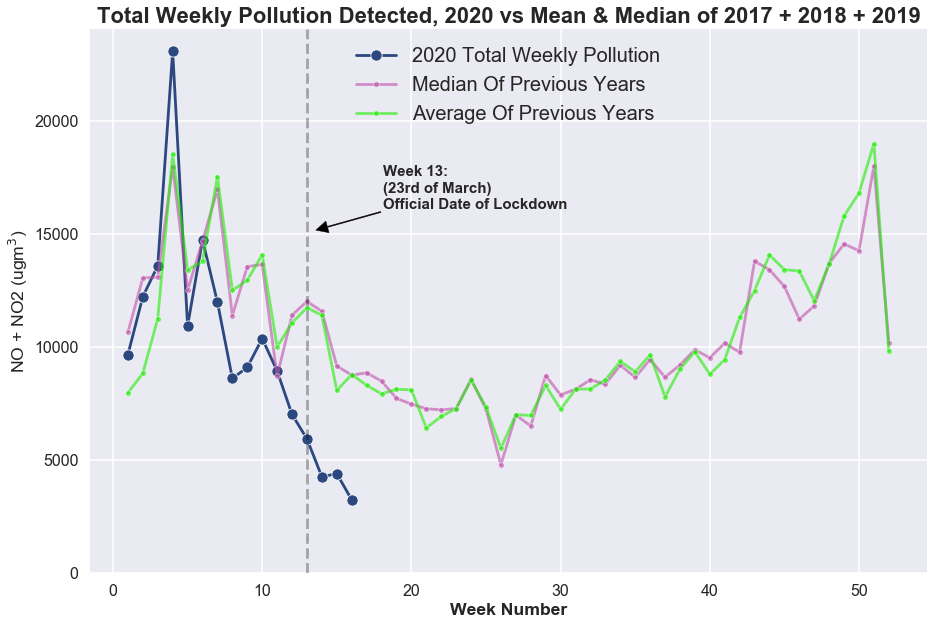

In [23]:
# plotting data
x = plt.figure(figsize=(15,10))
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['Median Over Previous Years'],
                 label='Median Of Previous Years',alpha=0.6,color='#be51a9',marker='.',ci=None)
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['Mean Over Previous Years'],
                 label='Average Of Previous Years',alpha=0.6,color='#1fed03',marker='.',ci=None)

plt.axvline(13, 0, 1,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.27,0.63),
                     xytext=(0.35,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('NO + NO2 (ugm$^3$)')
#plt.ylabel('Nitric oxide + Nitrogen dioxide (ugm$^3$)')
plt.xlabel('Week Number',fontdict={'fontweight':'bold'})
x.set_ylim(0,None)
#plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019',
         fontdict={'fontweight':'bold','fontsize':22})
plt.savefig('Images/05. Weekly 2020 Pollution VS Mean and Median Full.png',bbox_inches='tight')
plt.savefig('Images/05. Weekly 2020 Pollution VS Mean and Median Full Transparent.png',transparent=True)
plt.savefig('Images/05. Weekly 2020 Pollution VS Mean and Median Full Tight.png',bbox_inches='tight')


# would be great to also say % drop compared to median and mean

In [15]:
# Making better named df for instagram
pivoted_clean_limited_ = pivoted_clean_limited.copy()
pivoted_clean_limited_.index = pivoted_clean_limited.index.rename('Week Number')
pivoted_clean_limited_.rename(columns={'Median Over Previous Years':'Median Of 2017, 2018 & 2019',
                                                         '2020':'2020 Weekly Total Pollution',
                              'Mean Over Previous Years':'Average Of 2017, 2018 & 2019',
                               '% Of Median':'2020 as % Of Median Of Previous Years'},inplace=True)
pivoted_clean_limited_.iloc[:16,[1,3,4]]

,2020 Weekly Total Pollution,2020 as % Of Median Of Previous Years,% Change From Median
Week Number,,,
1,9657.67340,90.696335,-9.303665
2,12228.10082,93.691517,-6.308483
3,13594.20969,103.864522,3.864522
4,23087.62070,128.379031,28.379031
5,10926.84212,87.317497,-12.682503
6,14742.12310,100.409737,0.409737
7,11978.06989,70.569833,-29.430167
8,8601.56153,75.529752,-24.470248
9,9091.92489,67.077405,-32.922595


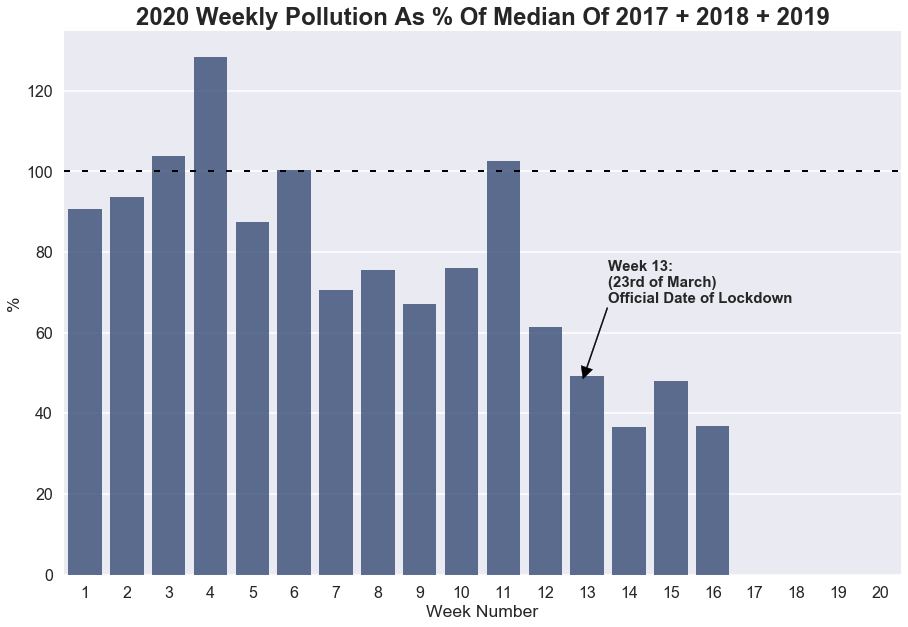

In [16]:
x = plt.figure(figsize=(15,10))

#x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['% Of Median'],label='2020 Total Weekly Pollution',
#             marker='o',alpha=1,color='#2C497F',ci=None)

x = sns.barplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['% Of Median'],label='2020 Total Weekly Pollution',
             alpha=0.8,ci=None,color='#2C497F')

# annotations
plt.axhline(y=100,linewidth=2, color='k',ls=(0,(3,6)))

plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.62,0.36),
                     xytext=(0.65,0.5), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')


# plot stylings
plt.style.use('seaborn-poster')
#plt.legend(loc='upper center')
plt.ylabel('%')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.title('2020 Weekly Pollution As % Of Median Of 2017 + 2018 + 2019',fontdict={'fontweight':'bold',                                                                            'fontsize':24})
plt.savefig('Images/06. 2020 Weekly Total Pollution Vs Median Of Previous Years.png',bbox_inches='tight')

# The weeks with lowest pollution on record

# Monthly Pivot

In [17]:
# Monthly pivot table with specific date range so only full months are measured
df_all_ = df_all.loc['2017-01-01':'2020-03-31'] 
monthly = df_all_.resample('M').sum()
month_piv = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
month_piv.columns=['2017','2018','2019','2020']

# new columns
month_piv['% of 2019'] = (month_piv['2020']/month_piv['2019'])*100
month_piv['% change'] = ((month_piv['2020']/month_piv['2019'])-1)*100

# median of previous years
z = month_piv.loc[:,['2017','2018','2019']].median(axis=1)
month_piv['Median Of Previous Years'] = z

# median columns 
month_piv['% Of Median'] = (month_piv['2020']/month_piv['Median Of Previous Years'])*100
month_piv['% Change From Median'] = ((month_piv['2020']/month_piv['Median Of Previous Years'])-1)*100

# cleaned up dataframe 
month_piv_clean = month_piv.iloc[:,[6,3,7,8]]

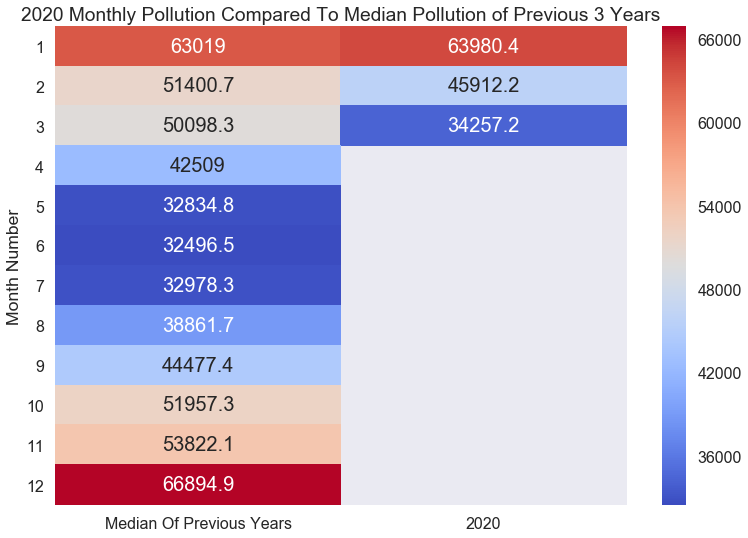

In [18]:
ax = sns.heatmap(month_piv_clean[['Median Of Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
#yticks(np.arange(12),['Jan','Feb','Mar','Apr','Jun','July','Aug','Sep','Oct','Nov','Dec'])
yticks(rotation=0)
title('2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')
plt.savefig('Images/07b. Monthly Pollution 2020 vs Median.png',bbox_inches='tight')

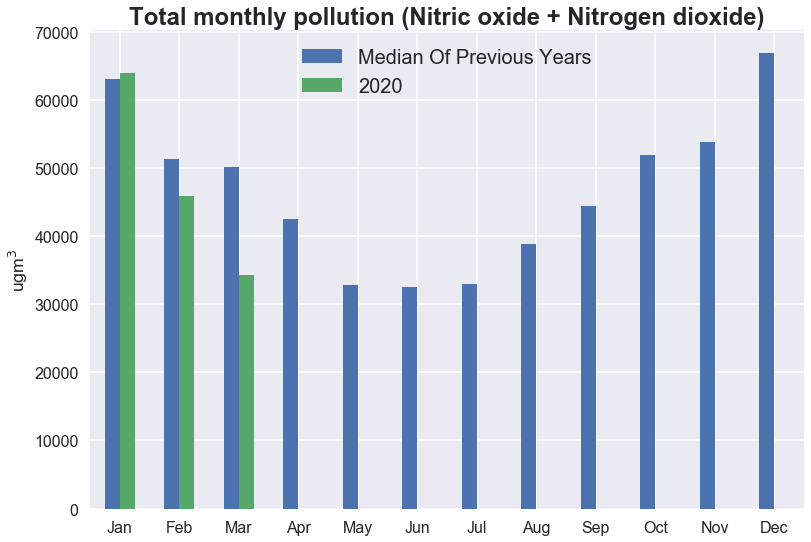

In [19]:
fig = month_piv_clean[['Median Of Previous Years','2020']].plot.bar()
# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('ugm$^3$')
plt.title('Total monthly pollution (Nitric oxide + Nitrogen dioxide)',fontdict={'fontweight':'bold','fontsize':24})
plt.xlabel('')
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=0)
fig.set_ylim(0,None)

plt.savefig('Images/07a. Monthly 2020 Pollution VS Median Of Previous Years.png',bbox_inches='tight')


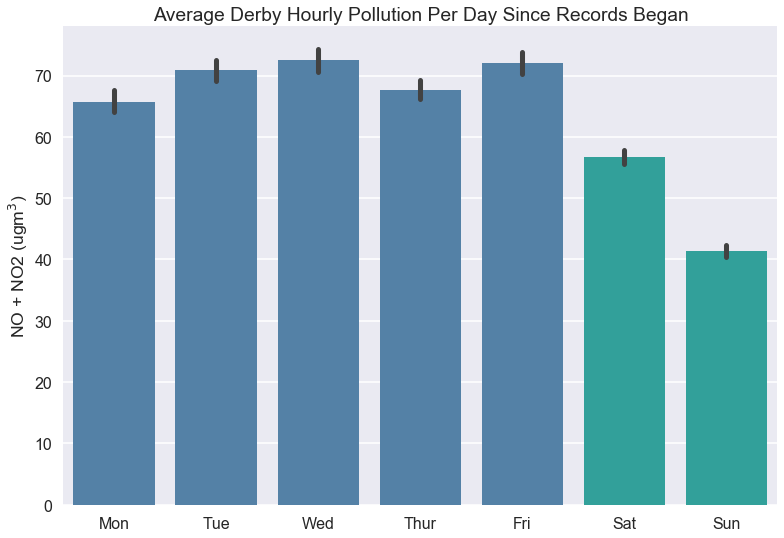

In [20]:
#sns.barplot(x='Day Of Week',y='Total',data=df_all,hue = 'Weekday Or Weekend')

sns.barplot(x='Day Of Week',y='Total',data=df_all,palette=['steelblue','steelblue','steelblue','steelblue',
                                                          'steelblue','lightseagreen','lightseagreen'])
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.ylabel('Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('')
plt.title('Average Derby Hourly Pollution Per Day Since Records Began')
plt.ylabel('NO + NO2 (ugm$^3$)')
plt.savefig('Images/08. Average Hourly Pollution Per Day.png',bbox_inches='tight')


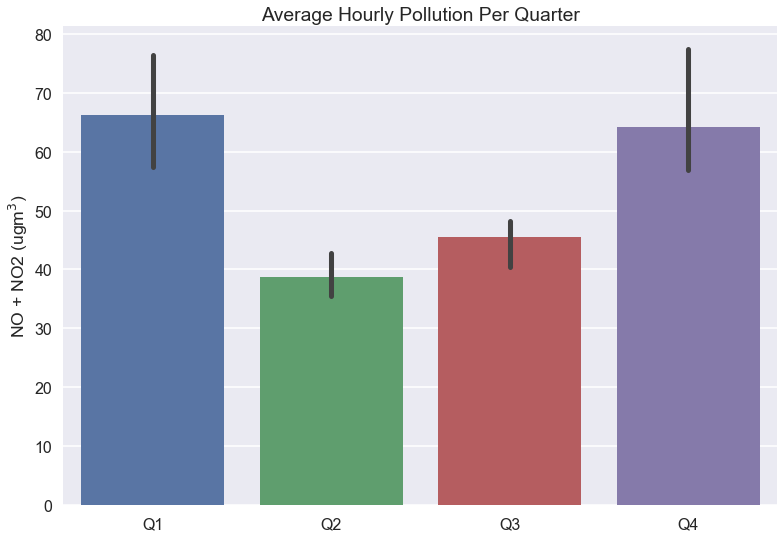

In [21]:
quart = df_all.loc['2017-01-01':'2019-12-31'].resample('Q').median()
quart = quart[['Total','Quarter']]
sns.barplot(x=quart.Quarter,y=quart.Total)

plt.xticks(np.arange(4),['Q1','Q2','Q3','Q4'])
plt.xlabel('')
plt.title('Average Hourly Pollution Per Quarter')
plt.ylabel('NO + NO2 (ugm$^3$)')
plt.savefig('Images/09. Average Hourly Pollution Per Quarter.png',bbox_inches='tight')


# Plotting months of all years next to each other 

FileNotFoundError: [Errno 2] No such file or directory: 'Derby images/7c. Monthly Pollution All Years.png'

<Figure size 1080x1080 with 0 Axes>

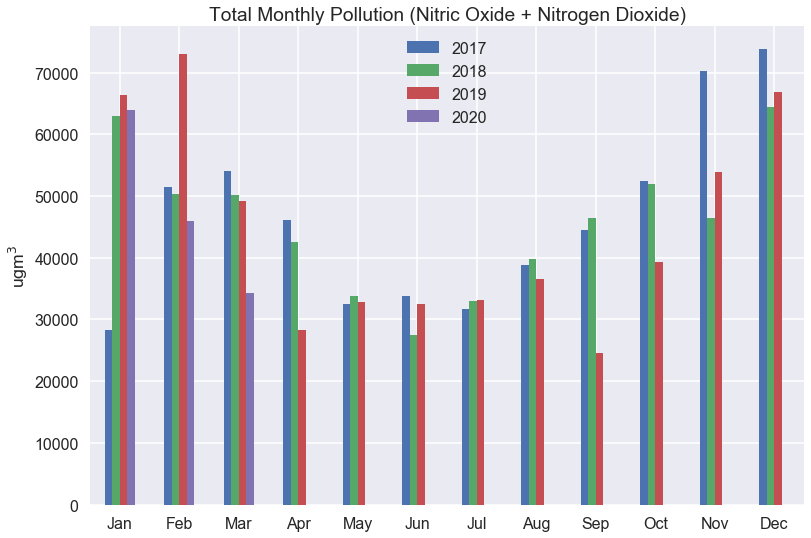

In [22]:
x = df_all.loc['2017-01-01':'2020-03-31'] # so it's only full months
# First, make pivot table
monthly = x.resample('M').sum()
pivoted = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
plt.figure(figsize=(15,15))
pivoted.plot(kind='bar')

# plot stylings
plt.title('Total Monthly Pollution (Nitric Oxide + Nitrogen Dioxide)')
plt.legend(loc='upper center')
plt.ylabel('ugm$^3$')
plt.xlabel('')
plt.xticks(rotation=0)
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.savefig('Derby images/7c. Monthly Pollution All Years.png',bbox_inches='tight')